In [351]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [352]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [353]:
time0 = time.time()

with open('../input/lendingclub0720-downsampled57/LCLoans_57_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)

df.drop(columns = ['pymnt_plan', 'fico_range_low', 'recoveries', 'collection_recovery_fee', 'last_fico_range_low', 'policy_code',
                  'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
                  'total_rec_late_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'last_fico_range_high',
                  'collections_12_mths_ex_med', 'acc_now_delinq'],inplace=True)
# fico bucket is always 5 points increment, so I drop lower bound as redundant info
# I drop most of the features above, since they seem to be collected after origination.
df.drop(columns = ['earliest_cr_line', 'issue_d', 'mths_since_last_record', 'mths_since_last_delinq',
                  'mths_since_last_major_derog'], inplace=True)
# these are useful features, which I will preprocess later
    
df = df.sample(400000)
display(df.shape, time.time()-time0, df.head())

(400000, 32)

0.6204097270965576

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
157523483,38000,38000,38000.0,36,10.33,1232.050049,B,B1,Technical Engineer III,3 years,MORTGAGE,138800.0,Verified,Current,credit_card,Credit card refinancing,029xx,RI,18.440001,0.0,714,0.0,16.0,1.0,15196,35.3,21.0,w,Individual,NaN,NaN,NaN
38416976,5375,5375,5375.0,36,10.49,174.679993,B,B3,registered dental hygienist,1 year,MORTGAGE,76000.0,Not Verified,Fully Paid,debt_consolidation,Debt consolidation,926xx,CA,18.000000,0.0,684,0.0,16.0,1.0,4081,31.2,18.0,f,Individual,NaN,NaN,NaN
145585842,8400,8400,8375.0,36,7.56,261.529999,A,A3,Sales and marketing,2 years,RENT,65000.0,Source Verified,Charged Off,debt_consolidation,Debt consolidation,271xx,NC,26.370001,0.0,834,1.0,8.0,0.0,2592,5.8,15.0,f,Individual,NaN,NaN,NaN
124949605,20000,20000,20000.0,60,20.00,529.880005,D,D4,Claims technical expert,7 years,MORTGAGE,78000.0,Source Verified,Fully Paid,credit_card,Credit card refinancing,937xx,CA,25.280001,0.0,664,0.0,18.0,0.0,15440,51.5,28.0,w,Individual,NaN,NaN,NaN
117879625,7000,7000,7000.0,36,13.59,237.860001,C,C2,Technician,< 1 year,RENT,30000.0,Source Verified,Current,other,Other,333xx,FL,4.960000,0.0,754,0.0,6.0,0.0,1205,12.1,6.0,w,Joint App,60000.0,6.08,Source Verified


In [354]:
display(df.loan_status.value_counts())
df.target=np.nan
df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             204502
Current                                                141294
Charged Off                                             49529
Late (31-120 days)                                       2231
In Grace Period                                          1366
Late (16-30 days)                                         373
Issued                                                    303
Does not meet the credit policy. Status:Fully Paid        257
Does not meet the credit policy. Status:Charged Off        88
Default                                                    57
Name: loan_status, dtype: int64

(256664, 33)

Fully Paid                                             204502
Charged Off                                             49529
Late (31-120 days)                                       2231
Does not meet the credit policy. Status:Fully Paid        257
Does not meet the credit policy. Status:Charged Off        88
Default                                                    57
Current                                                     0
In Grace Period                                             0
Issued                                                      0
Late (16-30 days)                                           0
Name: loan_status, dtype: int64

loan_amnt                    256664
funded_amnt                  256664
funded_amnt_inv              256664
term                         256664
int_rate                     256664
installment                  256664
grade                        256664
sub_grade                    256664
emp_title                    238344
emp_length                   240463
home_ownership               256664
annual_inc                   256664
verification_status          256664
loan_status                  256664
purpose                      256664
title                        253695
zip_code                     256664
addr_state                   256664
dti                          256510
delinq_2yrs                  256662
fico_range_high              256664
inq_last_6mths               256662
open_acc                     256662
pub_rec                      256662
revol_bal                    256664
revol_util                   256462
total_acc                    256662
initial_list_status         

52.2749662399292

### Feature Preprocessing

In [355]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>2, 'lti']=2
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df.emp_length = df.emp_length.astype(int)
display(df.emp_length.value_counts())

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint'], inplace=True)

ValueError: cannot convert float NaN to integer

In [ ]:
df.target.mean()

In [ ]:
train.head()

In [ ]:
cat_features_te = ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'purpose', 'title', 'zip_code', 'addr_state']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [ ]:
df.application_type.value_counts()

### EDA

In [ ]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

In [ ]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [ ]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [ ]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

In [356]:
#df[['fico_range_low', 'fico_range_high']].drop_duplicates().sort_values(['fico_range_low'])

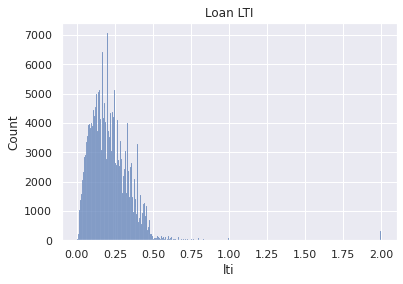

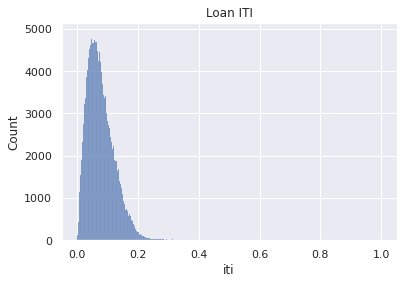

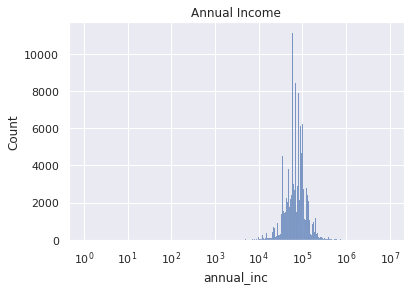

In [357]:
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()

[Text(0.5, 1.0, 'Loan Grade')]

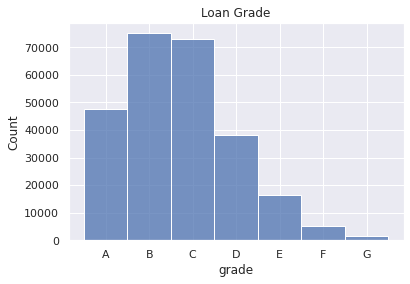

In [358]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')

### EDA with target

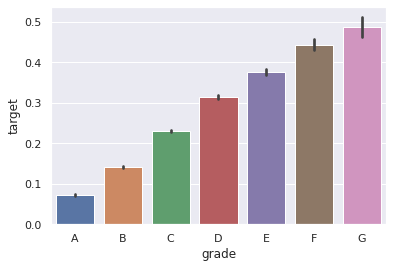

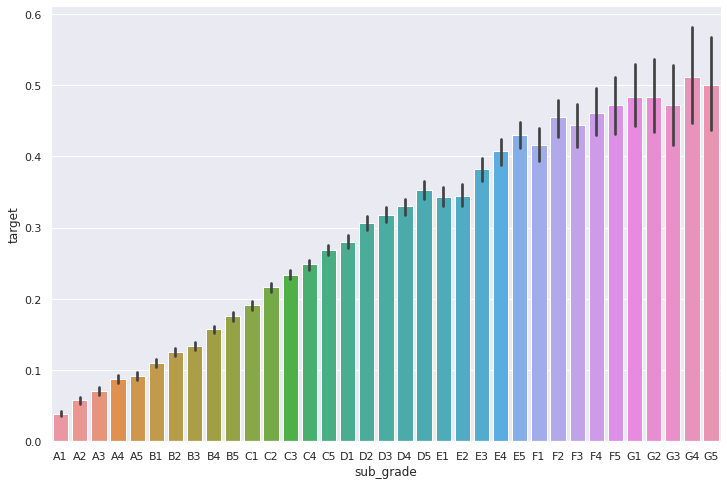

In [359]:
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()

### Train-test split, missing values

In [360]:
display(df.count())

loan_amnt                    256664
funded_amnt                  256664
funded_amnt_inv              256664
term                         256664
int_rate                     256664
installment                  256664
grade                        256664
sub_grade                    256664
emp_title                    238344
emp_length                   240463
home_ownership               256664
annual_inc                   256664
verification_status          256664
purpose                      256664
title                        253695
zip_code                     256664
addr_state                   256664
dti                          256510
delinq_2yrs                  256662
fico_range_high              256664
inq_last_6mths               256662
open_acc                     256662
pub_rec                      256662
revol_bal                    256664
revol_util                   256462
total_acc                    256662
initial_list_status          256664
application_type            

In [361]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc']

df['emp_length'] = df['emp_length'].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(230998, 35)

(25666, 35)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,target,lti,iti,joint
0,5375,5375,5375.0,36,10.49,174.679993,B,B3,registered dental hygienist,1,MORTGAGE,76000.0,Not Verified,debt_consolidation,Debt consolidation,926,CA,18.000000,0.0,684,0.0,16.0,1.0,4081,31.2,18.0,f,Individual,NaN,NaN,NaN,0.0,0.070724,0.027581,0
1,8400,8400,8375.0,36,7.56,261.529999,A,A3,Sales and marketing,2,RENT,65000.0,Source Verified,debt_consolidation,Debt consolidation,271,NC,26.370001,0.0,834,1.0,8.0,0.0,2592,5.8,15.0,f,Individual,NaN,NaN,NaN,1.0,0.129231,0.048282,0
2,20000,20000,20000.0,60,20.00,529.880005,D,D4,Claims technical expert,7,MORTGAGE,78000.0,Source Verified,credit_card,Credit card refinancing,937,CA,25.280001,0.0,664,0.0,18.0,0.0,15440,51.5,28.0,w,Individual,NaN,NaN,NaN,0.0,0.256410,0.081520,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,target,lti,iti,joint
180314,5500,5500,5500.0,36,10.90,179.809998,B,B4,IT/litigation support,8,RENT,60000.0,Verified,debt_consolidation,Debt consolidation,620,IL,25.139999,0.0,749,2.0,6.0,0.0,0,0.0,25.0,w,Individual,NaN,NaN,NaN,0.0,0.091667,0.035962,0
67993,14000,14000,14000.0,36,13.99,478.420013,C,C4,Raw Materials Manager,3,MORTGAGE,98000.0,Source Verified,credit_card,Credit card refinancing,463,IN,19.990000,0.0,674,4.0,24.0,1.0,13032,38.3,82.0,f,Individual,NaN,NaN,NaN,1.0,0.142857,0.058582,0
205552,8000,8000,8000.0,36,15.05,277.519989,C,C4,General Manager,8,MORTGAGE,140000.0,Not Verified,debt_consolidation,Debt consolidation,925,CA,6.150000,1.0,664,0.0,8.0,0.0,2576,43.7,13.0,w,Individual,NaN,NaN,NaN,0.0,0.057143,0.023787,0


loan_amnt                    230998
funded_amnt                  230998
funded_amnt_inv              230998
term                         230998
int_rate                     230998
installment                  230998
grade                        230998
sub_grade                    230998
emp_title                    230998
emp_length                   230998
home_ownership               230998
annual_inc                   230998
verification_status          230998
purpose                      230998
title                        230998
zip_code                     230998
addr_state                   230998
dti                          230998
delinq_2yrs                  230998
fico_range_high              230998
inq_last_6mths               230998
open_acc                     230998
pub_rec                      230998
revol_bal                    230998
revol_util                   230998
total_acc                    230998
initial_list_status          230998
application_type            

loan_amnt                    25666
funded_amnt                  25666
funded_amnt_inv              25666
term                         25666
int_rate                     25666
installment                  25666
grade                        25666
sub_grade                    25666
emp_title                    25666
emp_length                   25666
home_ownership               25666
annual_inc                   25666
verification_status          25666
purpose                      25666
title                        25666
zip_code                     25666
addr_state                   25666
dti                          25666
delinq_2yrs                  25666
fico_range_high              25666
inq_last_6mths               25666
open_acc                     25666
pub_rec                      25666
revol_bal                    25666
revol_util                   25666
total_acc                    25666
initial_list_status          25666
application_type             25666
annual_inc_joint    

### Categorical features encoding

In [362]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

21.481769323349

7.1730828285217285

(230998, 35)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,target,lti,iti,joint,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
0,5375,5375,5375.0,36,10.49,174.679993,1,76000.0,Not Verified,18.000000,0.0,684,0.0,16.0,1.0,4081,31.2,18.0,f,Individual,NaN,NaN,NaN,0.0,0.070724,0.027581,0,0.142900,0.134439,0.201872,0.173347,0.213197,0.217883,0.196448,0.200431
1,8400,8400,8375.0,36,7.56,261.529999,2,65000.0,Source Verified,26.370001,0.0,834,1.0,8.0,0.0,2592,5.8,15.0,f,Individual,NaN,NaN,NaN,1.0,0.129231,0.048282,0,0.070456,0.069889,0.201872,0.235307,0.213197,0.217883,0.158489,0.206225
2,20000,20000,20000.0,60,20.00,529.880005,7,78000.0,Source Verified,25.280001,0.0,664,0.0,18.0,0.0,15440,51.5,28.0,w,Individual,NaN,NaN,NaN,0.0,0.256410,0.081520,0,0.312610,0.329815,0.201872,0.173347,0.177367,0.182911,0.215457,0.200431
3,14000,14000,14000.0,60,18.55,359.720001,2,55000.0,Source Verified,21.730000,1.0,664,1.0,9.0,1.0,7175,60.3,31.0,w,Individual,NaN,NaN,NaN,0.0,0.254545,0.078484,0,0.375523,0.340763,0.229362,0.235307,0.177367,0.182911,0.216759,0.206225
4,21000,21000,21000.0,60,15.80,508.459991,2,78000.0,Verified,23.820000,0.0,694,0.0,15.0,0.0,38683,77.2,30.0,f,Individual,NaN,NaN,NaN,1.0,0.269231,0.078225,0,0.229905,0.229190,0.201872,0.235307,0.177367,0.182911,0.233645,0.204165


loan_amnt                    230998
funded_amnt                  230998
funded_amnt_inv              230998
term                         230998
int_rate                     230998
installment                  230998
emp_length                   230998
annual_inc                   230998
verification_status          230998
dti                          230998
delinq_2yrs                  230998
fico_range_high              230998
inq_last_6mths               230998
open_acc                     230998
pub_rec                      230998
revol_bal                    230998
revol_util                   230998
total_acc                    230998
initial_list_status          230998
application_type             230998
annual_inc_joint               8869
dti_joint                      8868
verification_status_joint      8587
target                       230998
lti                          230998
iti                          230998
joint                        230998
grade_encoded               

In [363]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,verification_status,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,annual_inc_joint,dti_joint,verification_status_joint,lti,iti,joint,grade_encoded,sub_grade_encoded,emp_title_encoded,home_ownership_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded
180314,5500,5500,5500.0,36,10.90,179.809998,8,60000.0,Verified,25.139999,0.0,749,2.0,6.0,0.0,0,0.0,25.0,w,Individual,NaN,NaN,NaN,0.091667,0.035962,0,0.143025,0.158530,0.188525,0.234895,0.213397,0.218342,0.199114,0.188108
67993,14000,14000,14000.0,36,13.99,478.420013,3,98000.0,Source Verified,19.990000,0.0,674,4.0,24.0,1.0,13032,38.3,82.0,f,Individual,NaN,NaN,NaN,0.142857,0.058582,0,0.230083,0.249248,0.202331,0.174325,0.178857,0.183679,0.212647,0.213990
205552,8000,8000,8000.0,36,15.05,277.519989,8,140000.0,Not Verified,6.150000,1.0,664,0.0,8.0,0.0,2576,43.7,13.0,w,Individual,NaN,NaN,NaN,0.057143,0.023787,0,0.230083,0.249248,0.203681,0.174325,0.213397,0.218342,0.185733,0.202450
115903,12000,12000,12000.0,36,6.89,369.929993,6,97885.0,Not Verified,21.719999,1.0,724,0.0,10.0,0.0,15228,35.0,41.0,w,Individual,NaN,NaN,NaN,0.122593,0.045351,0,0.071639,0.071755,0.205123,0.174325,0.213397,0.218342,0.183693,0.207878
80249,15000,15000,15000.0,36,16.02,527.510010,4,60000.0,Source Verified,11.800000,0.0,709,0.0,5.0,0.0,6387,53.2,7.0,f,Individual,NaN,NaN,NaN,0.250000,0.105502,0,0.230083,0.269568,0.202331,0.234895,0.213397,0.218342,0.198713,0.221020


Number of features before transaformation:  (230998, 34)
time to do feature proprocessing:  9.146521806716919
Number of features after transaformation:  (230998, 38)   cat__verification_status_Not Verified  \
0                                   1.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   

  cat__verification_status_Source Verified cat__verification_status_Verified  \
0                                      0.0                               0.0   
1                                      1.0                               0.0   
2                                      1.0                               0.0   
3                                      1.0                               0.0   
4                                      0.0                               1.0   

  cat__initial_list_status_f cat__initial_list_status_w  \
0                        1.0       

### Modeling

In [364]:
time.time()-time0

23.475872039794922